# Quantification

## Ladder

O'gene ruler 1kb ladder 2 ul.

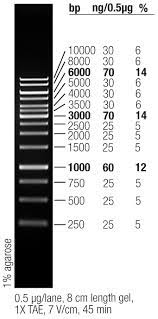

Concentration of ladder is 0.1 ug/uL.

In [1]:
from pathlib import Path
import pandas as pd

In [2]:
class AgaroseQuant():
    
    def __init__(self, image_path, layout_table_path, quant_path):
        self.image = Path(image_path)
        self.layout_table_path = Path(layout_table_path)
        self.quant_path = Path(quant_path)
        self.layout_table = self.layout_table_path
        self.quant_table = self.quant_path

    
    @property
    def layout_table(self):
        # by default assume provided as tsv file
        return self._layout_table
    
    @layout_table.setter
    def layout_table(self, filepath):
        self._layout_table = pd.read_csv(str(filepath), sep='\t')
    
    @property
    def quant_table(self):
        # assume exported from ImageLab program
        return self._quant_table
    
    @quant_table.setter
    def quant_table(self, filepath):
        self._quant_table = pd.read_csv(str(filepath), skiprows=1)

Quantify mass of DNA per lane by comparing each band's relative intensity to the 6000 bp band of the ladder.
Only marked bands in each lane are the supercoiled and relaxed bands. Summing these together and dividing by total sample volume per lane (1 ul) gives estimation
of sample concentration in ng/ul.

In [3]:
class T7InitQuant(AgaroseQuant):
    
    relative_ng_ug = 70  # from O'gene ruler 1kb
    volume_ladder = 2  # ul
    ladder_concentration = 0.1  # ug / ul
    volume_sample = 1  # ul
    
    def __init__(self, well_row_number, *args, **kwargs):
        self.well_row_number = well_row_number
        super(T7InitQuant, self).__init__(*args, **kwargs)
        
    
    
    @AgaroseQuant.layout_table.setter
    def layout_table(self, filepath):
        self._layout_table = pd.read_csv(str(filepath), sep='\t')
        # gel split into 3 images, label table contains all wells so need to split
        # by image before qunatification
        self._layout_table = self._layout_table.loc[self._layout_table['Well row'] == self.well_row_number]
    
    
    @property
    def relative_quant_mult(self):
        return ((T7InitQuant.ladder_concentration * T7InitQuant.volume_ladder) / 0.5) * T7InitQuant.relative_ng_ug
    
    def _quantify_bands(self):
        nanograms = self.quant_table['Rel. Quant.'] * self.relative_quant_mult
        self.quant_table['nanograms'] = nanograms
        
    
    def _sum_lanes_ng(self):
        self._quantify_bands()
        return pd.DataFrame(self.quant_table.groupby(['Lane'], as_index=False)['nanograms'].sum() / T7InitQuant.volume_sample)
        
        
    def label_quants(self):
        return pd.merge(
            self.layout_table, self._sum_lanes_ng(), 
            left_on='Lane number relative to row', right_on='Lane'
        )
    

In [4]:
labels = 'agaroseGelLayoutTables-1-14-21-T7-init-concentration-measurements.tsv'

In [5]:
data = [
    '2022-01-14_15h17m24s-t7-init-series-concentration-measure-1',
    '2022-01-14_15h22m17s-t7-init-series-concentration-measure-2',
    '2022-01-14_15h23m41s-t7-init-series-concentration-measure-3'
]

data_dir = Path('RelQuant')

In [6]:
quantifications = []

for gel in data:
    path_prefix = data_dir.joinpath(gel)
    image, quant_table = (path_prefix.with_suffix(s) for s in ['.png', '.csv'])
    row_number = int(str(path_prefix).split('-')[-1])  # last int is the well row number
    quant = T7InitQuant(row_number, image, labels, quant_table)
    quantifications.append(quant.label_quants())

In [7]:
t7_init_quant = pd.concat(quantifications)
t7_init_quant_sub = t7_init_quant[['Tube full name', 'Tube date', 'nanograms']]
t7_init_quant_sub

,Tube full name,Tube date,nanograms
0,pFC9-T7-init-VR1-midi-D,12/18/21,40.886664
1,pFC9-T7-init-VR2-midi-D,12/18/21,127.297884
2,pFC9-T7-init-VR3-midi-D,12/14/21,135.733584
3,pFC9-T7-init-VR4-midi-D,12/21/21,255.807468
4,pFC9-T7-init-VR5-midi-D,12/14/21,50.113952
5,pFC9-T7-init-VR6-midi-D,12/14/21,125.991516
6,pFC9-T7-init-VR7-midi-D,12/21/21,178.635688
7,pFC9-T7-init-VR8-midi-D,12/21/21,197.337952
8,pFC9-T7-init-VR9-midi-D,12/14/21,84.075264
9,pFC9-T7-init-VR10-midi-D,12/14/21,43.093904


In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')

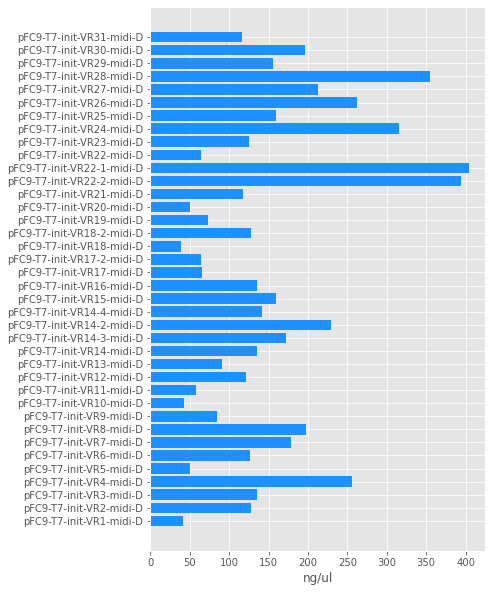

In [9]:
figure(figsize=(6, 10))
plt.barh(t7_init_quant['Tube full name'], t7_init_quant['nanograms'], color='dodgerblue')
plt.xlabel('ng/ul')
plt.savefig('t7InitSeriesConcentrationQuants.png', bbox_inches='tight')
plt.show()

In [10]:
t7_init_quant_sub.to_csv('t7InitSeriesConcentrationQuants.tsv', sep='\t', index=None)